In [1]:
import numpy as np
from sklearn.datasets import load_digits
import gtda.homology
import gtda.diagrams
import matplotlib.pyplot as plt
from  sklearn.preprocessing import StandardScaler
from skimage import filters
from scipy.signal import convolve2d

In [2]:
#Load data
digits = load_digits()
X = digits.data
X = np.reshape(X,(1797,8,8))

[0.26076598 0.22325919 0.15002288 0.11612563 0.08563277 0.05350206
 0.0495373  0.03813968 0.02301451]


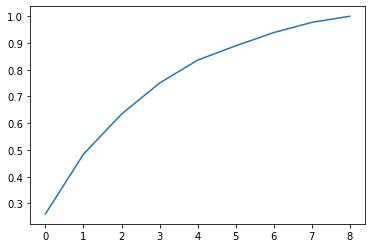

In [45]:
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA 
patches = []
for im in X:
    patches.extend(extract_patches_2d(im,(3,3)))
np.shape(patches)
patches = np.reshape(patches,(64692,9))
pca = PCA(n_components=9)
pca.fit(patches)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)
filters = []
f1 = np.reshape(pca.components_[0],(3,3))
f2 = np.reshape(pca.components_[1],(3,3))
f3 = np.reshape(pca.components_[2],(3,3))


In [46]:
#f1 = [[1,1,1],[1,1,1],[1,1,1]]
#f2 = [[1,0,1],[1,0,1],[1,0,1]]
#f3 = [[-1,0,1],[-1,0,1],[-1,0,1]]

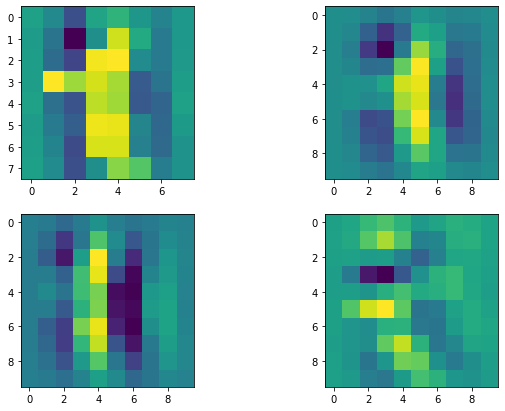

In [47]:
T = X[1]
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 2, 1)
plt.imshow(T)
fig.add_subplot(2, 2, 2)
plt.imshow(convolve2d(T,f1))
fig.add_subplot(2, 2, 3)
plt.imshow(convolve2d(T,f2))
fig.add_subplot(2, 2, 4)
plt.imshow(convolve2d(T,f3))

In [48]:
X_f1 = []
X_f2 = []
X_f3 = []
digits = load_digits()
for im in X:
    im_f1 = convolve2d(im,f1,'same')
    X_f1.append(im_f1)
    im_f2 = convolve2d(im,f2,'same')
    X_f2.append(im_f2)
    im_f3 = convolve2d(im,f1,'same')
    X_f3.append(im_f3)


In [49]:
scaler = StandardScaler()
def rescale(collection):
    collection = np.reshape(collection,(1797,64))
    collection = scaler.fit_transform(collection)
    return np.reshape(collection,(1797,8,8))


In [50]:
X = rescale(X)
X_f1 = rescale(X_f1)
X_f2 = rescale(X_f2)
X_f3 = rescale(X_f3)

In [51]:
B = 10
cubpers = gtda.homology.CubicalPersistence()
diagrams = cubpers.fit_transform(X)
persim  = gtda.diagrams.PersistenceImage(n_bins=B)
def im_2_persim(collection):
    diagrams = cubpers.fit_transform(collection)
    im = persim.fit_transform(diagrams)
    return np.reshape(im,(1797,2*B*B))

In [52]:
diagrams = im_2_persim(X)
diagrams_f1 = im_2_persim(X_f1)
diagrams_f2 = im_2_persim(X_f2)
diagrams_f3 = im_2_persim(X_f3)

In [53]:
total_diagrams = np.concatenate((diagrams,diagrams_f1,diagrams_f2,diagrams_f3),axis = 1)

In [54]:
#Load target data
from sklearn.preprocessing import OneHotEncoder
y = digits.target
enc = OneHotEncoder(sparse=False)
labels = enc.fit_transform(y.reshape(-1,1))

In [55]:
#Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(total_diagrams,labels, test_size=0.33, random_state=0)

In [56]:
#Model 1: KNN Classifier
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=13)
cv_results = cross_validate(neigh, total_diagrams, y, cv=3)
print(sorted(cv_results.keys()))
print(cv_results['test_score'])

['fit_time', 'score_time', 'test_score']
[0.34724541 0.37729549 0.31719533]


In [57]:
#Model 2: Boosted Trees.
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators = 100,random_state = 0)
cv_results = cross_validate(gb_model, total_diagrams, y, cv=3)
print(sorted(cv_results.keys()))
print(cv_results['test_score'])

['fit_time', 'score_time', 'test_score']
[0.5509182  0.59599332 0.57429048]


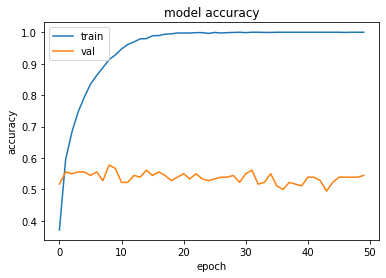

In [58]:
#Model 3: Deep Learning
from keras import models
from keras import layers
np.random.seed(0)
network = models.Sequential()
network.add(layers.Dense(units=100,input_dim = 8*B*B, activation='relu'))
network.add(layers.Dense(units=100, activation='relu'))
network.add(layers.Dense(units=10, activation='softmax'))
network.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
history = network.fit(total_diagrams, labels,validation_split = 0.1, epochs=50, batch_size=4,verbose=0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

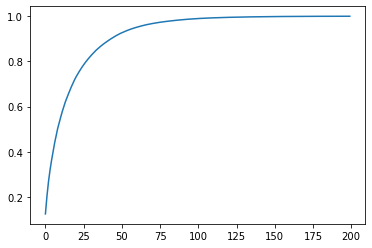

In [59]:
#Let's run these experiments again, now using PCA preprocessing
from sklearn.decomposition import PCA 
pca = PCA(n_components=200)
diagrams_pca = pca.fit_transform(total_diagrams)
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [60]:
#Model 1: KNN Classifier
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
cv_results = cross_validate(neigh, diagrams_pca, y, cv=3)
print(sorted(cv_results.keys()))
print(cv_results['test_score'])

['fit_time', 'score_time', 'test_score']
[0.32053422 0.32554257 0.30717863]


In [61]:
#Model 2: Boosted Trees.
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators = 100,random_state = 0)
cv_results = cross_validate(gb_model,diagrams_pca, y, cv=3)
print(sorted(cv_results.keys()))
print(cv_results['test_score'])

['fit_time', 'score_time', 'test_score']
[0.45075125 0.50083472 0.44741235]


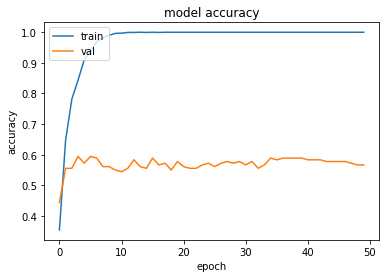

In [62]:
#Model 3: Deep Learning
from keras import models
from keras import layers
np.random.seed(0)
network = models.Sequential()
network.add(layers.Dense(units=100,input_dim = 200, activation='relu'))
network.add(layers.Dense(units=100, activation='relu'))
network.add(layers.Dense(units=10, activation='softmax'))
network.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
history = network.fit(diagrams_pca, labels,validation_split = 0.1, epochs=50, batch_size=4,verbose=0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()